# Python scripting for network analysis — IV

In [1]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Evenly distributed shortcuts

During the last lab, on March 5th, we have discussed how to calculate a computational estimate for the ring & shortcuts problem, calculating an estimate for the average clustering coefficient as $N \to \infty$. We have seen that this is significantly different than our theoretical estimate, and after some analysis, we concluded that one possible reason for the discrepancy is the different way the shortcuts are placed for the two estimates: The theoretical estimate assumes that every node gets exactly one shortcut edge, while due to the random placement of the shortcut edges for the computational estimate, some nodes will get more than one, while other won't receive any.

The next task is to do a computational estimate where the shortcuts are placed evenly, the same way they are for the theoretical estimate, and to check whether this resolves the discrepancy, or do we need additional mechanisms to fully explain it.

This means that we are going to be doing the same estimate as between, but changing some details in how the networks are generated.

This is the code we used last time to generate the network, including the code for checking that the generated networks are suitable:

In [2]:
import networkx
import random
import matplotlib.pyplot as plt

def ring_network(N):
    g = networkx.Graph()
    for i in range(N):
        g.add_edge(i, (i+1)%N)
        g.add_edge(i, (i+2)%N)
    return g

In [3]:
def add_shortcuts(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)):
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
    return graph

for i in range(10):
    g = add_shortcuts(ring_network(10))
    print(g.number_of_nodes(), g.number_of_edges())

10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25


# Modifying the code to place shortcuts evenly

It is very tempting to jump in and start modifying the code to match the new requirements, but I would recommend a different priority order: first update the validation code, i.e. the way we test the resulting networks. This is the same approach that the software development methodology "Test Driven Development" advocates, and the idea is that this way we are sure to have some tests, and also that by changing the test-code first, we will automatically check that the test code checks the aspect we want to: otherwise there is a risk that if the test-code is wrong, it will either test nothing, or it will test some unimportant aspect and it would have already accepted the original version, which we know it shouldn't.

The test in our case is fairly simple: we should check that the node degrees are all the same:

In [4]:
for i in range(10):
    g = add_shortcuts(ring_network(10))
    print(g.number_of_nodes(), g.number_of_edges(), set(dict(g.degree()).values()))

10 25 {4, 5, 6}
10 25 {4, 5, 6}
10 25 {4, 5, 6, 7}
10 25 {4, 5, 6, 7}
10 25 {8, 4, 5, 6}
10 25 {4, 5, 6}
10 25 {4, 5, 7}
10 25 {4, 5, 6}
10 25 {4, 5, 6}
10 25 {4, 5, 6, 7}


As we can see, we get various node degrees. With the correct code, we should get only {5} in the last column.

Now we can get to work changing the code to assign the shortcuts evenly. One idea we might have is to do the same thing we do for generating the shortcut edges: the inner loop in that case looks like this:

In [5]:
if False: # this is just a code example, we don't want to run this jupyter notebook cell
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)

I.e. we pick a pair of nodes at random, then we check whether they are suitable, and pick new ones if they are not. Once we do have a suitable pair, we accept them by adding the new edge.

Using the same idea we might do something like:

In [6]:
def ensure_evenly_distributed_shortcuts(N):
    g = add_shortcuts(ring_network(N))
    while len(set(dict(g.degree()).values())) != 1:
        g = add_shortcuts(ring_network(N))
    return g

In [7]:
for i in range(10):
    g = ensure_evenly_distributed_shortcuts(10)
    print(g.number_of_nodes(), g.number_of_edges(), set(dict(g.degree()).values()))

10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}
10 25 {5}


I.e. generate a network, check whether the shortcuts are placed evenly (since our add_shortcuts() method places shortcuts without bias, essentially selecting one instance from all possible ways of placing the shortcuts, it should occasionally return networks where the shortcuts happen to be placed evenly), and re-run the generation if it isn't. If we do get a suitable network, we can accept it by returning it.

This code appears to work fine for our small test code, but a major complaint with this first approach might be that we are wasteful: instead of generating all the shortcuts and then throwing all of them away if not all of them is perfectly evenly placed, we can ensure evenness during the generation. All we need, is remove the nodes which received a shortcut from the list "nodes" thereby ensuring that we won't try to add a new shortcut to these nodes. This results in the following:

In [8]:
def add_shortcuts_evenly(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)):
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
        nodes.remove(node_a); nodes.remove(node_b)
    return graph

Thus, we shouldn't need to re-run add_shortcuts_evenly, since any network it returns will have evenly placed shortcuts. To check that this is what happens, we can run our validating code:

In [9]:
for i in range(10):
    g = add_shortcuts_evenly(ring_network(10))
    print(g.number_of_nodes(), g.number_of_edges(), set(dict(g.degree()).values()))

10 25 {5}


KeyboardInterrupt: 

Well, apparently that is not we actually expected: it turns out, that instead of printing out the 10 lines (one for each network that is generated), we usually only get a few lines, and then the program appears to get stuck. The lines that are printed appear to indicate that the result is correct (the shortcuts are placed evenly), but very often a result is not actually generated.

To stop such a stuck script from the jupyter notebook interface, we can use the "Interrupt" entry in the "Kernel" menu, which causes a KeyboardInterrupt exception. (This also allows us to check where the program got stuck.) When running a .py script from the command line, one can use Ctrl-C to send the same interrupt.

Debugging such a script can be often problematic: we don't get a nice error message, simply nothing happens instead. Also, whether the script gets stuck or not will be random: re-running the code it might or might not get stuck again. Thus, it is very important to understand what goes wrong, and what can, in general, go wrong in such situations.

The first question is: is the script actually stuck, or is it just very slow? Our first variant, ensure_evenly_distributed_shortcuts() for example, will show similar behaviour when run for larger network sizes, for example when trying to generate networks of 100 nodes. Assuming that our code (add_shortcuts and ring_network) from the last lab is correct (i.e. it generates networks without bias and without being stuck), that shouldn't actually get stuck: with a certain probability, we will get a network that has the shortcuts evenly placed thus we allways have a chance to finish. If we analyze add_shortcuts_evenly(), however, we will notice that it does actually get stuck, i.e. it ends up in an infinite loop.

Before we look into that analysis, a general warning about infinite loops: in python, "for" loops are generally iterations over a datastructure (for example a dictionary or a list). Thus, we can trust that they won't become infinite loops. A "while" loop, however, runs until the condition is satisfied. Usually our code needs to do something to satisfy that condition, thus if something goes wrong, we can quite easily end up with an infinite loop. Whenever writing a "while" loop, always consider this possibility, and chech whether the condition will actually be satisfied at some point, or are you going to end up with an infinte loop.

(A footnote: it is actually possible to have a "for" loop be an infinite loop: all that is required is that the datastructure it iterates over is infinitely big. This might sound very strange, but we have already seen a datastructure that is "infinitely big" in some respect: collections.defaultdict() pretends to already have all keys defined. Since iterating over it will only iterate over keys that were actually used, we won't get an infinite loop. However, other objects might be infinite: a good example is itertools.repeat() -- called with one argument, it will return that object for each iteration, endlessly.)

So, what might be happening in our case? Why might our condition never be satisfied? One possible way to find out is to run the code, wait until it gets stuck, and after interrupting it, use a debugger (in jupyter notebook, run "%debug" to start a pdb instance) to look at the state of the program: how many shortcuts were placed, how many nodes still lack a shortcut, etc. Alternatively, trying to think of scenarios which might cause the code to end up in an infinite loop we might quickly get to the conclusion that the issue is with placing the last shortcut: as we add shortcuts, we remove items from the "nodes" list. It might happen that we get to the last 2 nodes and they are already connected in the original ring (they are neighbors or second-neighbors). In this case, we will pick these 2 nodes over and over but we will never be able to place a new shortcut: thus, we are stuck.

Now that we understand that the code can get stuck, the two questions we need to answer are:
1. How to detect that we are stuck? As we can see, we will get stuck at random, i.e. occasionally the function will finish sucessfully and return a network
1. What to do to fix being stuck?

# How to detect that we are stuck?

One possibility is to do the same thing that we have done by hand: i.e. declare that the program is stuck if we have to wait too long. Searching online we can find, for example some "timeout decorator" libraries for python (see for example https://github.com/pnpnpn/timeout-decorator ) which allow adding a watchdog to the code, setting a timeout and triggering an exception if the code runs longer than that timeout. Then, we can catch the exception that is raised and proceed accordingly.

Of course, this approach has many drawbacks: we need to guess the timeout, and we will most likely waste a lot of CPU time needlessly running the code when it is already stuck, just to wait for the timeout to expire. (Setting a low timeout is also bad, since that will increase the false positives, i.e. it will trigger even if we are not yet stuck and we could continue.

Another possibility is to use our knowledge of the problem: since we get stuck when we cannot place the last shortcut, simply check that the last shortcut can be placed (where we don't have any choice anyway, so trying to pick the last to nodes at random won't actually change anything), and if not, we know that we are stuck. This is much better, since it doesn't waste any CPU time, but obviously it requires a correct understanding of why we get stuck. (We will come back to this question in a moment.)

# What to do to fix being stuck?

Once we have detected that we are stuck, we will need to do something different to finish the network. Some basic options are:

1. undo the last step: If we are stuck, we could take a step back, i.e. remove a shortcut we have placed previously, and then continue again, hopefully in a different direction.
1. remove the obstacle that is blocking us: if the problem is that we can't place the last shortcut, we could move some of the existing shortcuts around to allow us to finish.

Both of these are quite reasonable, and can be implemented with more or less effort. A somewhat stranger approach might also be suggested, however: simply do nothing. Obviously that won't fix the problem itself, but we might get away with it, if we use a clever argument: 

# Just ignore the problem

If the problem is with the very last shortcut, and happens only occasionally, what if we simply ignore that, and return the network? Strictly speaking, the network won't be correct, but we could argue that we are generating an approximation of the network. After all, we are going to be calculating an estimate as $N \to \infty$, so we could argue that as long as the difference between the actual networks and those generated by our code is negligible in this limit, it should be usable for the estimate. We have already made a similar approximation, when deriving the theoretical estimate, where we neglected the triangles created by the shortcut edges.

This sounds quite reasonable, but I want to emphasize that it is only acceptable if we also add this argument: i.e. it is perfectly ok to make approximations, but we need to state explicitly what the estimate is, why it is acceptable, as well as (as much as possible) when it will be valid. If we simply write a script that doesn't actually create networks that it should, and don't add such a argument, then our entire estimate should be considered wrong, the same way a mathematical derivation is only correct if every step in it is correct.


# Just give up and call a function

If we don't want to do use such an approximation, another option could be to simply give up when we are stuck, and call a function to return a correctly generated network instead. This idea sure sounds sound silly, since we are actually working on such a function -- why would we want to work on such a function if we could simply call one? Still, it is actually an interesting possibility, as the following code example shows:

In [ ]:
def add_shortcuts_evenly_just_call_a_function_to_fix_when_stuck(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    graph_copy = graph.copy()
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)-1): # all but one shortcuts
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
        nodes.remove(node_a); nodes.remove(node_b)
    # try to place last shortcut
    node_a, node_b = nodes
    if not graph.has_edge(node_a, node_b):
        graph.add_edge(node_a, node_b)
    else:
        return add_shortcuts_evenly_just_call_a_function_to_fix_when_stuck(graph_copy)
    
    return graph

The changes that were needed in the code above:
1. in the main "for" loop, add one less shortcuts than needed (i.e. leave the last shortcut until the end)
1. after the main "for" loop, check whether we can place the last shortcut -- if not, call ourselves recursively
1. due to the recursive call, we will need to keep a copy of the network. Create this copy at the beginning of the function.

Note that this code is essentially doing something very similar to the shortcut generation or to ensure_evenly_distributed_shortcuts() -- it tries to generate a network, and if it fails, it throws it away and starts again. Its just that instead of a while loop, this variant uses a recursive call to accomplish that. This of course also means that we will need to be similarly careful to avoid infinite loops: if no network can be generated then such an algorithm might call itself over and over again with no hope of success.
(Note that depending on the language and runtime environment, this might not actually mean an infinite loop: many environments, for example python have a maximum recursion depth that will limit how deep the chain of functioncalls can be, and thus limit the maximum number of iterations that might happen in this case.)

# Some performance aspects

There is one more option we will discuss, but before that we should say a few words about the performance aspects of these 4 variants that we have mentioned so far. In particular, lets consider the following two variants:

In [ ]:
def ensure_evenly_distributed_shortcuts(N):
    g = add_shortcuts(ring_network(N))
    while len(set(dict(g.degree()).values())) != 1:
        g = add_shortcuts(ring_network(N))
    return g

def add_shortcuts_evenly(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)):
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
        nodes.remove(node_a); nodes.remove(node_b)
    return graph

Since we know that the second variant (add_shortcuts_evenly) will turn into an infinite loop when the last shortcut cannot be placed, one might assume that the first one (ensure_evenly_distributed_shortcuts) is strictly better. However, that will show a very serious problem if we try to generate larger networks: it will also appear to get stuck. It won't actually end up in an infinite loop, as long as there is some possibility of placing the shortcuts evenly (for example, we will need even number of nodes to ensure this). With some analysis, we can see that ensure_evenly_distributed_shortcuts simply becomes very slow, instead of actually getting stuck. The reason for this is simple: as the network gets larger and larger, it becomes less and less likely that we place the shortcuts evenly when we place them randomly. A good way to visualize this is to consider the set of all possible networks. The fraction of the networks where the shortcuts are placed evenly will become a smaller and smaller fraction as the size increases. Due to "unbiased sampling" aspect of using a PRNG, when generating a network, we are basically picking one element from this at random.

The second variant, add_shortcuts_evenly() doesn't have this slow-down problem: if it can generate a network (and not get stuck), it will generate it quite efficiently. Why? Because it won't have to throw away generated networks due to the un-evenness of the shortcut placement. It doesn't do trial-and-error, thus it won't need to re-try over and over again. (Note that even that variant uses trial-and-error, since it has a while loop to re-generate the shortcut if it is a self-loop or already part of the network. But to ensure the evenness of the shortcuts, it does not need it.)

In this case, the add_shortcuts_evenly ensures that our condition (about the evenness of the shortcuts) is met by removing the nodes from the list we pick from. This will mean that whatever shortcut we generate during the next iteration, this condition will already be satisfied. This sounds like a very good property from a stochastic algorithm, since as we have seen, in some cases a trial-and-error algorithm might have incredibly poor performance. Could we use something similar in other situations?

The problem will be: how can we generalize such a strategy? The trial-and-error strategy is nicely generalizable, since in the condition (in our case, the condition of the "while" loop) we can essentially put any condition we wish. What we did with "remove node from 'nodes'" doesn't look similarly generalizable. The general idea, to "not generate something we cannot use", can be done in a general manner, however.

As we have mentioned earlier, we can imagine that what our program essentially does is to pick one network from a set of all networks. In general, similar "generate one instance of an object that fulfills some conditions" algorithms can be considered to be doing such sampling. A very direct way of implementing such a sampling would be to do just that: explicitly create a set (or list) of all options, then use a single call to random.choice() to pick one of these. This list-and-choose method ensures that we don't need to do trial-and-error: whatever we pick will be suitable (since all items that we pick from is suitable), and thus there is no risk of ending up with an infinite loop. (Note that there is still a possibility that we can't generate the object as requested, since that depends not on our algorithm, but on the conditions: if those conditions contradict each other, for example, then we won't be able to generate the object since none would be suitable. But even in this case this list-and-choose method has a better behaviour, since what will happen is that the "list all options" will result in an empty list, and it will be quite explicit that there are no valid options. This is much easier to debug and reason about than an infinite loop.)

An example to show these two different strategies is the following snippets of code which generate one shortcut: the first one is what we used in add_shorcuts(), while the second one is a list-and-choose approach which generates the list of all possibilities using the complement network (which contains the same nodes, but has an edge between two nodes if and only if they are not connected in the original network).

In [ ]:
node_a = random.choice(graph.nodes()); node_b = random.choice(graph.nodes())
while graph.has_edge(node_a, node_b) or node_a == node_b:
    node_a = random.choice(graph.nodes()); node_b = random.choice(graph.nodes())
graph.add_edge(node_a, node_b)

In [ ]:
all_possible_shortcuts = networkx.complement(graph).edges()
new_edge = random.choice(all_possible_shortcuts)
graph.add_edge(new_edge[0], new_edge[1])

Can we use this list-and-choose method directly for generating the network? That would involve listing out all valid possibilities for arranging the shortcuts, which for larger networks is going to be astronomical. This isn't realistic. Considering the performance implications of these two strategies, we can arrive at the following:
1. trial-and-error is quick when there are very many possibilities and a large fraction of those are valid. In this case, list-and-choose will be very resource-intensive
1. list-and-choose is much better when only a small set of possibilities are valid: enumerating all of these is reasonable, but trial-and-error can be very slow as this means that valid choices are generated with very low probability.

Note that these two are, in many respects, complementary: i.e. in the cases where list-and-choose is unreasonable, trial-and-error is quite good, and vice versa. This also means that if the conditions change as our program runs, the best option might be to switch from one to the other. One example implementation of this approach:
(note that this is mostly to show what implementing this "switch strategies" approach might look like. In many aspects, this is far from optimal, in order to simplify the code. For example to check which options for placing the last three shortcuts is valid, it simply adds them to a copy of the network, i.e. it will make a bunch of copies of the network, which will be quite slow for large networks.)

In [10]:
import itertools

def add_shortcuts_evenly_strategy_switch(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)-3):# place all but three of the shortcuts with the trial-and-error strategy
        node_a = random.choice(nodes); node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes); node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
        nodes.remove(node_a); nodes.remove(node_b)

    # For the last three shortcuts, place them with the "generate all possibilities and choose from them" strategy.
    # In this case, each candidate will be a valid way to place all three remaining shortcuts
    nodes_without_shortcuts = [node for node,k in dict(graph.degree()).items() if k == 4]
    valid_permutations = []
    edges_before_finish = graph.number_of_edges()
    for permutation in itertools.permutations(nodes_without_shortcuts):
        # To check whether these shortcuts are valid, we use a quick-and-dirty trick:
        # we actually place them (in a copy of the network) and check whether to resulting
        # network is okay. This avoid having to code complicated validation code here,
        # and also avoids the risk of getting that validation code wrong.
        g = graph.copy()
        pairs = zip(permutation[::2], permutation[1::2])
        for i,j in pairs:
            g.add_edge(i,j)
        if g.number_of_edges() == edges_before_finish+3:
            valid_permutations.append(permutation)

    # Once we have all candiates, we can simply pick one and place the shortcuts
    # note that we have no additional validation here -- we have done all that above.
    permutation_to_use = random.choice(valid_permutations)
    pairs = zip(permutation_to_use[::2], permutation_to_use[1::2])
    for i,j in pairs:
        graph.add_edge(i,j)
    return graph 


One important aspect of switching strategies is switching at the right moment: if we want to be really optimal, we would need to work out exactly when one list-and-choose becomes better than trial-and-error, which might also depend on the tradeoff between memory usage (since list-and-choose might need a lot of memory, if there are many options to choose from) and CPU runtime (of which we will use more if we need to re-try more using trial-and-error).

The add_shortcuts_evenly_strategy_switch implementation above does not try to be optimal in this regard, it simply switches quite late. But even then, to avoid having to do some backtracking or similar fixes, it should switch before the code actually gets stuck. How can we ensure this? An important consideration here is to look at worst-case scenarios: what is the earliest that we can get stuck? Maybe we can be already stuck even if we can still place some shortcuts, if no matter how we place them, we won't be able to finish. With a bit of analysis, we will notice that the interesting situation to consider is when all the remaining nodes are next to each other: the main problem is that shortcut edges we might want to place are already part of the network, and that will happen if the nodes are neighbors in the original ring. Obviously if the last 2 nodes are neighbors, we can't finish, but we can quickly check that if the last 4 nodes are next to each other, the same is true: even though we can place one shortcut, but we won't be able to place 2. 

What we need to consider is "what is the largest number of nodes next to each other where we can still finish?" This will give us "the latest in the worst-case scenario where we can still finish". Drawing some examples, we can quickly convince ourselves that the answer is 6 nodes (i.e. when 3 shortcuts need to be placed). The function add_shortcuts_evenly_strategy_switch above uses this condition: it places all but 3 of the shortcuts with trial-and-error, and uses list-and-choose for the last 3.

# What to expect for similar problems

Note that all of our variants above are:
* longer than our code from last week
* run slower than last week's code

This is a pretty general experience: if we add more and more conditions about the object we are generating, doing the generation will be slower, and will require more programming effort. In addition, if we try optimize the code, we will have to be especially careful to ensure "unbiased sampling" -- for the first approach I would recommend using either a trial-and-error or list-and-choose approach, with as few tricks as possible. (For example, if we do some sort of backtracking, or rewiring already placed edges, we will have to be careful to ensure those steps don't introduce some bias.)

# Calculating the estimate

Calculating the average clustering coefficient, and then the estimate as $N \to \infty$ can be done the same way as we did during the last lab. One point to emphasize here: although we quite clearly want to compare our estimate to the theoretical result, but we should do that only after we have arrived at an estimate. I.e. we should consider the task to be to calculate an estimate, and then compare that estimate to the other estimates. If we are too focused on the other estimates we are trying to match, we might end up accidentially biasing our estimate -- to ensure that the two estimates are actually independent, we should do the comparison only as a second task.
(A good rule of thumb is that if two results match too well, then it is likely that they were not calculated independently: for example in this case our theoretical estimate is exactly 0.3. If we announce that our computational estimate is also 0.3, with no error bars or random noise, that clearly shows that we were biased by the theoretical estimate.)

In our case, plotting the same type of convergence plot, we get:

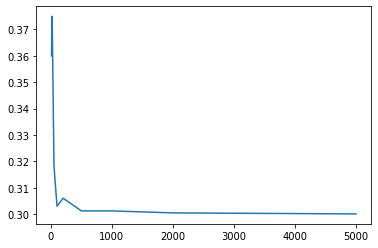

In [11]:
N_values = [10,20,50,100,200,500, 1000, 2000,5000]
values = [networkx.average_clustering(add_shortcuts_evenly_strategy_switch(ring_network(N))) for N in N_values]
plt.plot(N_values, values)

The plot shows very good convergence, but to get a numerical result, we should also look at the data directly:

In [12]:
values

[0.36,
 0.375,
 0.3180000000000003,
 0.30300000000000044,
 0.305999999999999,
 0.3012,
 0.3012000000000055,
 0.30045000000000005,
 0.3000599999999728]

From which our numerical estimate might be the interval from 0.3 to 0.3002. (Note that although the theoretical estimate is 0.3, at the very edge of this interval, but our computational estimate converges to it from the top, so we can still consider the two estimates to match.)